In [1]:
import sys

sys.path.append("../")
from tensorflow.keras.applications.VGG19 import VGG19
from funciones import *

Modulo importado con exito.... :)


In [2]:
K.clear_session() #limpiamos todos en caso de nuevo entrenamiento
img_width=224
img_height=224
INIT_LR = 1e-3
batch_size=50
epochs=100

#CARGANDO LOS DATASETS
path_root='../../Dataset Real Bananos MRefinados/'
path_train=path_root+'train'
path_validation=path_root+'validation'

train_gen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

validation_gen= ImageDataGenerator(rescale=1./255)

image_train=train_gen.flow_from_directory(
    path_train,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

image_validation=validation_gen.flow_from_directory(
    path_validation,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical'
)
nClasses=len(image_train.class_indices)
print(image_train.class_indices)

Found 2384 images belonging to 4 classes.
Found 795 images belonging to 4 classes.
{'Class A': 0, 'Class B': 1, 'Class C': 2, 'Class D': 3}


In [3]:
#Construccion del modelo

vgg19_arch=VGG19(input_shape=(img_width,img_height,3),
                                 weights=None, #aqui se puede aplicarTransfer Learning
                                 include_top=False)
vgg19_arch.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [4]:
model = Sequential()
model.add(vgg19_arch)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(nClasses, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
    optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dropout (Dropout)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              39322624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [5]:
step_train=image_train.n//image_train.batch_size
step_validation=image_validation.n//image_validation.batch_size

In [6]:
#EMPEZANDO EL ENTRENAMIENTO
history=model.fit_generator(image_train,
                  steps_per_epoch=step_train,
                  epochs=epochs,
                  #callbacks=[early_stop, tfdocs.modeling.EpochDots()],
                  verbose=1,
                  validation_data=image_validation,
                  validation_steps=step_validation
                  )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
47/47 [==============================] - 27s 579ms/step - loss: 1.1961 - accuracy: 0.4820 - val_loss: 1.4836 - val_accuracy: 0.2547
Epoch 2/100
47/47 [==============================] - 23s 497ms/step - loss: 0.8373 - accuracy: 0.6392 - val_loss: 1.8860 - val_accuracy: 0.2307
Epoch 3/100
47/47 [==============================] - 24s 501ms/step - loss: 0.6758 - accuracy: 0.7185 - val_loss: 2.4320 - val_accuracy: 0.2280
Epoch 4/100
47/47 [==============================] - 23s 492ms/step - loss: 0.6002 - accuracy: 0.7515 - val_loss: 2.5281 - val_accuracy: 0.2240
Epoch 5/100
47/47 [==============================] - 23s 497ms/step - loss: 0.5207 - accuracy: 0.7819 - val_loss: 2.7459 - val_accuracy: 0.2280
Epoch 6/100
47/47 [==============================] - 23s 493ms/step - loss: 0.5231 - accuracy: 0.8008 - val_loss: 3.4185 - val_accuracy: 0.2280
Epoch 7/100
47/47 [==============================] - 23s 500

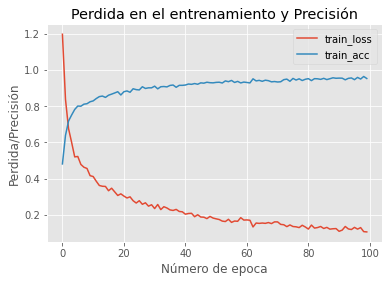

In [7]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,epochs),history.history['loss'],label="train_loss")
plt.plot(np.arange(0,epochs),history.history['accuracy'],label="train_acc")
plt.title("Perdida en el entrenamiento y Precisión")
plt.xlabel("Número de epoca")
plt.ylabel("Perdida/Precisión")
plt.legend(loc="upper right")
plt.show()

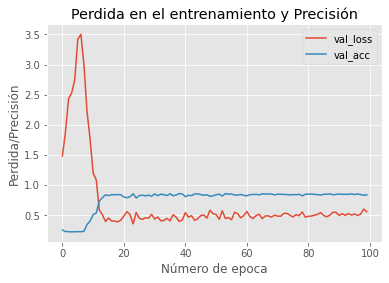

In [8]:
plt.plot(np.arange(0,epochs),history.history['val_loss'],label="val_loss")
plt.plot(np.arange(0,epochs),history.history['val_accuracy'],label="val_acc")
plt.title("Perdida en el entrenamiento y Precisión")
plt.xlabel("Número de epoca")
plt.ylabel("Perdida/Precisión")
plt.legend(loc="upper right")
plt.show()

In [25]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
path_test=path_root+"test_junto"
test_gen=test_datagen.flow_from_directory(
    path_test,
    target_size=(img_width,img_height),
    color_mode='rgb',
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)


Found 0 images belonging to 0 classes.


In [47]:
steps_size_test+test_gen.n//test_gen.batch_size
pred=model.predict_generator(test_gen,steps=steps_size_test,verbose=1)
predicted_class_index=np.argmax(pred,axis=1)
print(predicted_class_index)

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 3, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 3, 1,
       1, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 2, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 0, 0, 1,
       1, 3, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 3,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 3, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 3, 0, 3, 0, 0, 3, 1, 2, 1, 1, 0, 2,
       1, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 2, 0, 0, 0, 2,
       2, 2, 0, 2, 2, 2, 1, 3, 2, 0, 1, 2, 2, 1, 0, 2, 2, 3, 3, 3, 0, 3,
       2, 1, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 0, 0,
       1, 2, 2, 2, 3, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2,

In [35]:
#_, acc = model.evaluate(X_test, y_one_hot_test, verbose=0)
#print('> %.3f' % (acc * 100.0))

ValueError: in user code:

    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\engine\training.py:1176 test_step
        self.compiled_loss(
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\Users\Integradora\Documents\MI-Fase2_Banano\entornos virtuales\entrenamiento_CNN386\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 1) and (32, 4) are incompatible


In [12]:
path_modelo='./modelos/ipception_resnetV2.h5'
model.save(path_modelo)

In [13]:

# entry point, run the example
run_example(path_test+"/780_tipoA.png",path_modelo)

TypeError: unhashable type: 'numpy.ndarray'